# Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import maxwell, gaussian_kde
from scipy import stats
import astropy.constants as cons
import h5py

# Functions

### Orbital Velocity ($v_{orb}$)
Two masses $m_1$ and $m_2$ are in binary. For $m_1$, the orbital velocity is $v_{orb,1}$ and period $P$. The separation between $m_1$ and $m_2$ is $a$.
$$
\frac{\mu v_{orb,1}^2}{a} = \frac{Gm_1m_2}{a^2}
$$
where $\mu$ is the reduced mass $\frac{m_1m_2}{m_1+m_2}$. Hence
$$
v_{orb,1}^2 = \frac{G(m_1+m_2)}{a} = \frac{Gm_1(1+Q)}{a} = \frac{G.(M_{\odot}\text{ in kg})}{(\text{AU in m})} \Big( \frac{m_1}{M_{\odot}} \Big) \Big( \frac{a}{AU} \Big)^{-1} (1+Q)
$$
$Q$ is the mass ratio $m_2/m_1$.

In [2]:
def func_vorb(m1, Q, a):
    '''
    Computes orbital velocity of each of the neutron stars
    Args:
        m1: primary mass
        Q: mass ratio
        a: separation
    Returns:
        vorb: array of orbital velocities of each of the neutron stars
    '''
    
    AU_to_m = 1.496e+11
    Solar_M_in_kg = 1.989e+30

    return ((cons.G.value*Solar_M_in_kg/AU_to_m) * m1 * (1+Q) / a)**0.5/1000 # km/s

### Kick Velocity ($v_{kick}$)
The kick velocity, $v_{kick}$ is assumed to be Maxellian with $\sigma_{kick}=265 km/s$ (consistent with Hobbs et al. 2005).

In [3]:
def func_vkick(vorb, sigma_kick = 265, fallback_fraction = 0.0):
    '''
    draw a natal-kick from a Maxwell-Boltzmann distribution
    with sigma_kick = 265  # km/s
    Args:
        vorb: orbital velocity
        sigma_kick: sigma of the Maxwell-Boltzmann distribution
        fallback_fraction: fallback_fraction, default=0
    Returns:
        vkick: array of kick velocities of each of the neutron stars
    '''

    return maxwell(loc=0., scale=sigma_kick).rvs(size=vorb.shape[0]) # km/s

### Survival Probability of the Hevier Star in Binary from Supernova Natal Kick ($f_{SN1}$): the Main Function we Want to Calculate

In [4]:
def func_fSN1(vorb, vkick):
    '''
    Computes survival probability of the first neutron star
    given the orbital velocity and kick velocity
    Args:
        vorb: orbital velocity
        vkick: kick velocity
    Returns:
        fSN1: survival probability of the first neutron star
    '''
    
    x = vkick - vorb
    kernel = gaussian_kde(x)
    return 1-kernel.integrate_box_1d(low=0, high=100000)

### A Class to Draw Random Variables from Power Law
Taken from: https://github.com/farr/BumpCosmology/blob/main/src/scripts/mock_injections.py

In [5]:
class PowerLawPDF(object): # Taken from https://github.com/farr/BumpCosmology/blob/main/src/scripts/mock_injections.py
    def __init__(self, alpha, a, b):
        assert alpha > 1

        self.alpha = alpha
        self.a = a
        self.b = b

        self.norm = (self.a - (self.a/self.b)**self.alpha*self.b)/(self.a*(self.alpha-1))

    def __call__(self, x):
        return (self.a/x)**self.alpha/self.a/self.norm
    
    def icdf(self, c):
        return ((self.a**self.alpha*self.b*c + self.a*self.b**self.alpha*(1-c))/(self.a*self.b)**self.alpha)**(1/(1-self.alpha))

rng = np.random.default_rng(333165393797366967556667466879860422123)

### Wind Mass Loss
Details of the functions: https://github.com/LiekeVanSon/ZdependentFormEff/blob/master/code/Vorb_vs_Vkick.ipynb

In [6]:
###########################################
# Computing the luminosity of a naked helium star
###########################################
# Hurley 2000 : the terminal age He-MS luminosity for a stripped star following Hurley
def L_THEMS(M_hei):
    """
    Hurley 2000
    """
    # eq. 82
    alpha = np.maximum(0, 0.85 - 0.08 * M_hei)

    # eq. 77
    L_ZHe = (15262 * M_hei**10.25) / (
        M_hei**9 + 29.54 * M_hei**7.5 + 31.18 * M_hei**6 + 0.0469
    )

    # L_THEMS eq. 80
    L_THEMS = L_ZHe * (1 + 0.45 + alpha)

    return L_THEMS  # L/Lsun


def LM_Grafener2011(M, F1=3.017, F2=2.446, F3=-0.306):
    """Mass Luminosity relation for H-free stars
    eq 10 in
    https://arxiv.org/pdf/1106.5361.pdf
    """
    logL_Lsun = F1 + F2 * np.log10(M) + F3 * np.log10(M) ** 2
    return 10**logL_Lsun

In [7]:
###########################################
# Different wind-mass-loss prescriptions
###########################################
# Hamman & Koesterke 1998 (old default COMPAS)
def HamannKoesterke1998(L, Z, Zsun = 0.014, fWR=1.0):
    """
    Eq 9 from Belczynski 2010
    http://arxiv.org/abs/0904.2784
    Should be based on Hamann & Koesterke 1998: (based on 62 WN stars)
    https://ui.adsabs.harvard.edu/abs/1998A&A...335.1003H/abstract
    But I never actually found this equation in here???
    """
    Mdot = fWR * 1e-13 * (L / cons.L_sun) ** 1.5 * (Z / Zsun) ** 0.86
    return np.log10(Mdot) # log10 Msun yr^-1

print('HamannKoesterke1998 at 1e5Lsun = ', HamannKoesterke1998(1e5*cons.L_sun, 0.014, fWR=1.0) )

##################
# Vink 2017
def Vink2017(L, Z, Zsun=0.014):
    """
    Equation 1 in Vink 2017
    Theoretical mass loss rates for He stars in the range 2-20 Msun
    https://arxiv.org/abs/1710.02010
    Derived for Z/Zsun = 1 − 1e−2 and mass range 2 - 60 Msun
    """
    logL = np.log10(L / cons.L_sun)
    logMdot = -13.3 + 1.36 * logL + 0.61 * np.log10(Z / Zsun)

    return logMdot

print('Vink2017 at Zsun and 1e4Lsun = ', Vink2017(1e4*cons.L_sun, 0.014, Zsun=0.014) )

# Sander & Vink 2020
def SanderVink2020(L, Z, Zsun = 0.014):
    """
    Eq 13 and 18-20 in Andreas & Vink 2020
    https://arxiv.org/abs/2009.01849
    
    + Temperature correction from Sander et al. 2023
    https://www.aanda.org/articles/aa/full_html/2023/02/aa45110-22/aa45110-22.html

    !! Takes L in L/Lsun, i.e. 2e5,  (many values return NAN)

    """
    # Mass lumminosity relation for nakeed He stars
    # L = 170761.47525570545 #LM_Grafener2011(M, F1 = 3.017, F2=2.446, F3 = -0.306) #L/Lsun
    # print('for M = ', M, 'L = ', L)
    # general wind mass loss prescription
    alpha      = 0.32 * np.log10(Z/Zsun) + 1.4
    logL0_Lsun = -0.87*np.log10(Z/Zsun) + 5.06 
    logMdot10  = -0.75 * np.log10(Z/Zsun) - 4.06 
    
    log_Mdot2020   = alpha * np.log10(np.log10(L) - logL0_Lsun) + 0.75 * (np.log10(L) - logL0_Lsun - 1.0) + logMdot10

    # Temperature correction to the SanderVink2020 prescription # I dont have Teff for now
    # if Teff > 1e5:
        # M_SV2023 = M_SV2020 - 6 * np.log10( Teff/(141 *1e3) )
    logMdot = log_Mdot2020 #- 6 * np.log10(1e5/(141 *1e3) )

    return  logMdot # log10 Msun yr^-1

print('SanderVink2020 at Zsun and 2e5Lsun', SanderVink2020(2e5, 0.014, Zsun=0.014) )


# Combined WR winds for low and high L combining Vink 2017 + Sander & Vink 2020
def WRwind_SV(L, Z, Zsun=0.014):
    """
    Combined WR wind prescription for low and high luminosity
    """
    M_vink2017 = Vink2017(L*cons.L_sun, Z, Zsun=Zsun) #log10(Mdot)
    # print('M_vink2017',M_vink2017)
    M_SV2020 = SanderVink2020(L, Z, Zsun=Zsun) #log10(Mdot)
    # print('M_SV2020', M_SV2020)

    # Replace NaN values with small number
    M_vink2017 = np.where(np.isnan(M_vink2017), -99, M_vink2017)
    M_SV2020 = np.where(np.isnan(M_SV2020), -99, M_SV2020)

    return np.maximum(M_vink2017, M_SV2020) #log10(Mdot)

HamannKoesterke1998 at 1e5Lsun =  -5.5
Vink2017 at Zsun and 1e4Lsun =  -7.86
SanderVink2020 at Zsun and 2e5Lsun -5.494327973120155


In [8]:
###########################################
# Computing the mass losst 
###########################################
# estimate of total mass lost from WR-like winds during the He-MS phase
from cProfile import label


def dM_wind(M_He_i, Z, L_hestar = 'Hurley', WR_wind = 'SanderVink'):
    """
    !!! Make sure to provide:
    M_he in Msun
    Z         ----- Metallicity   
    L_hestar  ----- What M-L relation to use ['Hurley', Grafener2011]
    WR_wind   ----- What WR wind mass loss to use [HamannKoest, 'SanderVink']
    """

    # Compute He star luminosity from the mass
    if L_hestar == 'Hurley':
        L_Lsun = L_THEMS(M_He_i)    # 10**5.4 #/cons.L_sun.value # Lsun  (taken from Spera + 2019 SEVN paper, fig 1)
    if L_hestar == 'Grafener2011':
        L_Lsun = LM_Grafener2011(M_He_i)
    # print( 'log10 L_Lsun', np.log10(L_Lsun), '\n')

    # Calculate He main sequence time
    tau_He_MS = 2.9e9 * (M_He_i) * L_Lsun**-1 #(L_sun/L)  # in years
    # print('tau_He_MS', tau_He_MS*1e-6, 'Myr \n')

    if WR_wind == 'SanderVink':
        dotM_WR = 10**WRwind_SV(L_Lsun, Z, Zsun = 0.014)
    elif WR_wind == 'HamannKoest':
        dotM_WR = 10**HamannKoesterke1998(L_Lsun*cons.L_sun, Z, fWR = 1.).value
    else:
        raise ValueError('WR wind prescription not recognized')

    # print('log $\dot{M}_{WR}$', np.log10(dotM_WR) )

    dM_wind = tau_He_MS * dotM_WR

    return dM_wind # Msun

### Primary Mass ($m_1$), Mass Ratio (q), and Separation (a) Post First Mass Transfer

#### Without Wind Mass Loss

In [9]:
def func_m1Qa_wo_WML(powerlawindex, mmin, mmax, mNSmin, mNSmax, qmin, qmax, logamin, logamax, fcore, beta, ndraw=10**7):
    '''
    function to determine primary mass, mass ratio, and separation
    Args:
        powerlawindex: power law index of intial mass function
        mmin: minimum mass of intial mass function
        mmax: maximum mass of intial mass function
        mNSmin: minimum ZAMS mass required to form NS
        mNSmax: maximum ZAMS mass required to form NS
        qmin: minimum mass-ratio of the initial mass ratio distribution
        qmax: maximum mass-ratio of the initial mass ratio distribution
        logamin: logarithm of the minimum separation of initial separation distribution
        logamax: logarithm of the maximum separation of initial separation distribution
        fcore: fraction of mass forming core
        beta: mass-transfer efficiency
    Returns:
        m1, Q, a: array of primary mass, mass-ratio, separation post first mass-transfer
    '''

    m1i = PowerLawPDF(powerlawindex, mmin, mmax).icdf(rng.uniform(low=0, high=1, size=ndraw)) # Solar mass
    m1i = m1i[m1i>mNSmin]
    m1i = m1i[m1i<mNSmax]
    m1 = fcore*m1i
    ndraw = m1.shape[0]
    
    Qi = np.random.uniform(0.01, 1.0, size=ndraw)
    Q = (Qi+beta*(1-fcore))/fcore
    
    logai = rng.uniform(low=np.log(0.01), high=np.log(1000), size=ndraw) # AU
    ai = np.exp(logai)
    a = ai*(1/fcore**2)*((Q+1)/(fcore*Q+1))*np.exp(2*Q*(fcore-1))

    return m1, Q, a

#### With Wind Mass Loss

In [10]:
def func_m1Qa_w_WML(m1_before_mass_loss, Q_before_mass_loss, a_before_mass_loss, Z, L_hestar = 'Hurley', WR_wind = 'SanderVink'):
    
    wind_mass_loss = dM_wind(m1_before_mass_loss, Z)
    m1 = m1_before_mass_loss - wind_mass_loss
    Q = (Q_before_mass_loss*m1_before_mass_loss - dM_wind(Q_before_mass_loss*m1_before_mass_loss, Z))/m1
    a =  a_before_mass_loss * (m1_before_mass_loss / m1)
    
    return m1, Q, a

# Computation

### Variation with Mass Transfer Efficiency ($\beta$)

"masklat = np.logical_and(betaarray>0.249, betaarray<0.255)\nmasklat1 = np.logical_and(betaarray>0.745, betaarray<0.751)\nlat = [betaarray[masklat][0], betaarray[masklat][0], betaarray[masklat1][0], betaarray[masklat1][0]]\nlong = [min(fSN1array_varbeta), fSN1array_varbeta[masklat][0], fSN1array_varbeta[masklat1][0], min(fSN1array_varbeta)]\n\nlat = np.append(lat, lat[0])\nlong = np.append(long, long[0])  \n\nplt.gca().add_patch(plt.Polygon(np.c_[lat,long], facecolor = 'red', alpha=0.1))\nplt.gca().autoscale()\n\nlat1 = [min(betaarray), betaarray[masklat][0], betaarray[masklat1][0], min(betaarray)]\nlong1 = [fSN1array_varbeta[masklat][0], fSN1array_varbeta[masklat][0], fSN1array_varbeta[masklat1][0], fSN1array_varbeta[masklat1][0]]\n\nlat = np.append(lat1, lat1[0])\nlong = np.append(long1, long1[0])  \n\nplt.gca().add_patch(plt.Polygon(np.c_[lat1,long1], facecolor = 'red', alpha=0.1))\nplt.gca().autoscale()\nplt.text(x=0.05, y=0.2, s='Feasible Region', fontsize=15)"

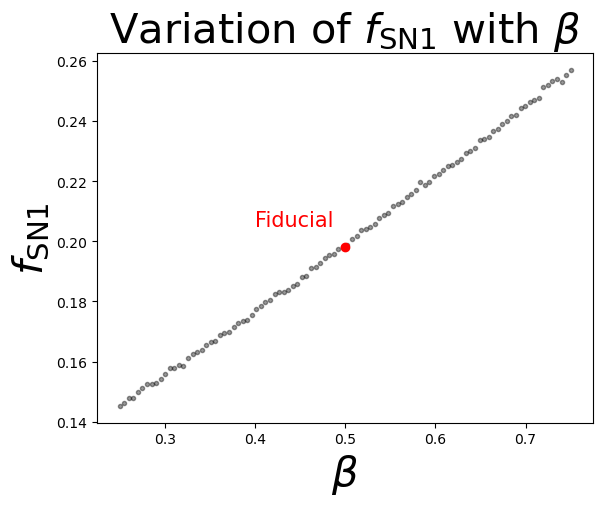

In [11]:
betaarray = np.linspace(0.25, 0.75, 100)
fSN1array_varbeta = []
for beta in betaarray:
    m1, Q, a = func_m1Qa_wo_WML(powerlawindex=2.7, mmin=1.0, mmax=300.0, mNSmin=6.0, mNSmax=20.0, qmin=0.2, qmax=1.0,
              logamin=np.log(0.01), logamax=np.log(1000), fcore=0.35, beta=beta)
    vorb = func_vorb(m1, Q, a)
    vkick = func_vkick(vorb)
    fSN1array_varbeta.append(func_fSN1(vorb, vkick))
fSN1array_varbeta = np.array(fSN1array_varbeta)

plt.scatter(betaarray, fSN1array_varbeta, color='k', marker='.', alpha=0.4)
plt.xlabel(r'$\beta$', fontsize=30)
plt.ylabel(r'$f_{\text{SN1}}$' , fontsize=30)
plt.title(r'Variation of $f_{\text{SN1}}$ with $\beta$', fontsize=30);

plt.scatter(0.5, fSN1array_varbeta[np.argmin(np.abs(betaarray-0.5))], color='r')
plt.text(x=0.4, y=0.205, s='Fiducial', color='r', fontsize=15)

'''masklat = np.logical_and(betaarray>0.249, betaarray<0.255)
masklat1 = np.logical_and(betaarray>0.745, betaarray<0.751)
lat = [betaarray[masklat][0], betaarray[masklat][0], betaarray[masklat1][0], betaarray[masklat1][0]]
long = [min(fSN1array_varbeta), fSN1array_varbeta[masklat][0], fSN1array_varbeta[masklat1][0], min(fSN1array_varbeta)]

lat = np.append(lat, lat[0])
long = np.append(long, long[0])  

plt.gca().add_patch(plt.Polygon(np.c_[lat,long], facecolor = 'red', alpha=0.1))
plt.gca().autoscale()

lat1 = [min(betaarray), betaarray[masklat][0], betaarray[masklat1][0], min(betaarray)]
long1 = [fSN1array_varbeta[masklat][0], fSN1array_varbeta[masklat][0], fSN1array_varbeta[masklat1][0], fSN1array_varbeta[masklat1][0]]

lat = np.append(lat1, lat1[0])
long = np.append(long1, long1[0])  

plt.gca().add_patch(plt.Polygon(np.c_[lat1,long1], facecolor = 'red', alpha=0.1))
plt.gca().autoscale()
plt.text(x=0.05, y=0.2, s='Feasible Region', fontsize=15)'''
#plt.savefig('../plots/varbetafSN1.pdf', bbox_inches='tight')

#### Variation with Metallicity (Z)

In [12]:
array_Z = np.logspace(-4, np.log10(0.03), 100)

fSN1_Z_varbeta = []
for beta in [0.25, 0.5, 0.75]:
    fSN1 = []
    for Z in array_Z:
    
        m1_before_mass_loss, Q_before_mass_loss, a_before_mass_loss = func_m1Qa_wo_WML(powerlawindex=2.7, mmin=1.0, mmax=300.0, mNSmin=6.0, mNSmax=20.0, qmin=0.2, qmax=1.0,
                  logamin=np.log(0.01), logamax=np.log(1000), fcore=0.35, beta=beta)
        m1, Q, a = func_m1Qa_w_WML(m1_before_mass_loss, Q_before_mass_loss, a_before_mass_loss, Z)
        vorb = func_vorb(m1, Q, a)
        vkick = func_vkick(vorb)
        vorb = func_vorb(m1, Q, a)
        fSN1.append(func_fSN1(vorb, vkick))
    fSN1_Z_varbeta.append(np.array(fSN1))
fSN1_Z_varbeta = np.array(fSN1_Z_varbeta)

'''plt.scatter(array_Z, fSN1)
plt.xlabel("$\log_{10}(Z/\mathrm{Z}_{\odot}$)", fontsize=30)
plt.ylabel("$f_{SN1}$", fontsize=30)'''

/tmp/ipykernel_2822477/2597507195.py:54: RuntimeWarning: invalid value encountered in log10
  log_Mdot2020   = alpha * np.log10(np.log10(L) - logL0_Lsun) + 0.75 * (np.log10(L) - logL0_Lsun - 1.0) + logMdot10


'plt.scatter(array_Z, fSN1)\nplt.xlabel("$\\log_{10}(Z/\\mathrm{Z}_{\\odot}$)", fontsize=30)\nplt.ylabel("$f_{SN1}$", fontsize=30)'

### Variation with $f_{core}$

Text(0.35, 0.205, 'Fiducial')

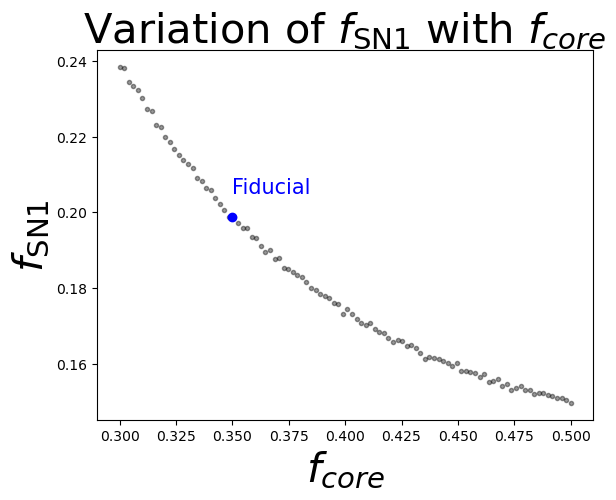

In [13]:
fcorearray = np.linspace(0.3, 0.5, 100)
fSN1array_varfcore = []
for fcore in fcorearray:
    m1, Q, a = func_m1Qa_wo_WML(powerlawindex=2.7, mmin=1.0, mmax=300.0, mNSmin=6.0, mNSmax=20.0, qmin=0.2, qmax=1.0,
              logamin=np.log(0.01), logamax=np.log(1000), fcore=fcore, beta=0.5)
    vorb = func_vorb(m1, Q, a)
    vkick = func_vkick(vorb)
    fSN1array_varfcore.append(func_fSN1(vorb, vkick))
fSN1array_varfcore = np.array(fSN1array_varfcore)

plt.scatter(fcorearray, fSN1array_varfcore, color='k', marker='.', alpha=0.4)
plt.xlabel(r'$f_{core}$', fontsize=30)
plt.ylabel(r'$f_{\text{SN1}}$' , fontsize=30)
plt.title(r'Variation of $f_{\text{SN1}}$ with $f_{core}$', fontsize=30);

plt.scatter(0.35, fSN1array_varfcore[np.argmin(np.abs(fcorearray-0.35))], color='b')
plt.text(x=0.35, y=0.205, s='Fiducial', color='b', fontsize=15)

#plt.savefig('../plots/varfcorefSN1.pdf', bbox_inches='tight')

In [14]:
fSN1_Z_varfcore = []
for fcore in [0.3, 0.35, 0.5]:
    fSN1 = []
    for Z in array_Z:
    
        m1_before_mass_loss, Q_before_mass_loss, a_before_mass_loss = func_m1Qa_wo_WML(powerlawindex=2.7, mmin=1.0, mmax=300.0, mNSmin=6.0, mNSmax=20.0, qmin=0.2, qmax=1.0,
                  logamin=np.log(0.01), logamax=np.log(1000), fcore=fcore, beta=0.5)
        m1, Q, a = func_m1Qa_w_WML(m1_before_mass_loss, Q_before_mass_loss, a_before_mass_loss, Z)
        vorb = func_vorb(m1, Q, a)
        vkick = func_vkick(vorb)
        vorb = func_vorb(m1, Q, a)
        fSN1.append(func_fSN1(vorb, vkick))
    fSN1_Z_varfcore.append(np.array(fSN1))
fSN1_Z_varfcore = np.array(fSN1_Z_varfcore)

/tmp/ipykernel_2822477/2597507195.py:54: RuntimeWarning: invalid value encountered in log10
  log_Mdot2020   = alpha * np.log10(np.log10(L) - logL0_Lsun) + 0.75 * (np.log10(L) - logL0_Lsun - 1.0) + logMdot10


### Variation with Width of the Kick Velocity Distribution

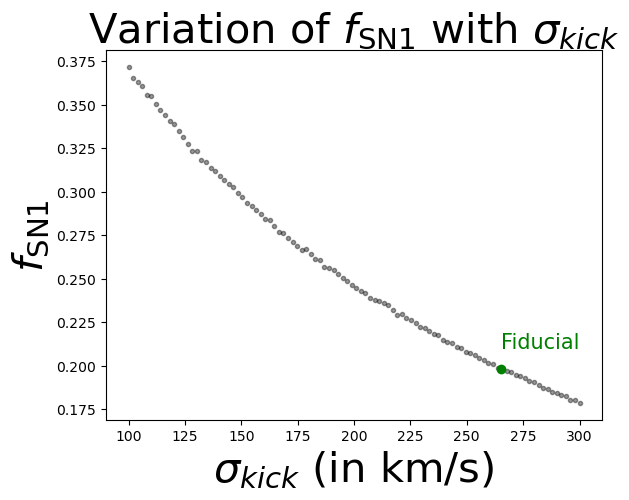

In [15]:
sigmakickarray = np.linspace(100, 300, 100)
fSN1array_varsigmakick = []
for sigmakick in sigmakickarray:
    m1, Q, a = func_m1Qa_wo_WML(powerlawindex=2.7, mmin=1.0, mmax=300.0, mNSmin=6.0, mNSmax=20.0, qmin=0.2, qmax=1.0,
              logamin=np.log(0.01), logamax=np.log(1000), fcore=0.35, beta=0.5)
    vorb = func_vorb(m1, Q, a)
    vkick = func_vkick(vorb, sigma_kick=sigmakick)
    fSN1array_varsigmakick.append(func_fSN1(vorb, vkick))
fSN1array_varsigmakick = np.array(fSN1array_varsigmakick)

plt.scatter(sigmakickarray, fSN1array_varsigmakick, color='k', marker='.', alpha=0.4)
plt.xlabel(r'$\sigma_{kick}$ (in km/s)', fontsize=30)
plt.ylabel(r'$f_{\text{SN1}}$' , fontsize=30)
plt.title(r'Variation of $f_{\text{SN1}}$ with $\sigma_{kick}$', fontsize=30);

plt.scatter(265.0, fSN1array_varsigmakick[np.argmin(np.abs(sigmakickarray-265.0))], color='g')
plt.text(x=265, y=0.21, s='Fiducial', color='g', fontsize=15)

plt.savefig('../plots/varsigmakickfSN1.pdf', bbox_inches='tight')

In [16]:
fSN1_Z_varsigmakick = []
for sigma_kick in [100, 265, 300]:
    fSN1 = []
    for Z in array_Z:
    
        m1_before_mass_loss, Q_before_mass_loss, a_before_mass_loss = func_m1Qa_wo_WML(powerlawindex=2.7, mmin=1.0, mmax=300.0, mNSmin=6.0, mNSmax=20.0, qmin=0.2, qmax=1.0,
                  logamin=np.log(0.01), logamax=np.log(1000), fcore=0.35, beta=0.5)
        m1, Q, a = func_m1Qa_w_WML(m1_before_mass_loss, Q_before_mass_loss, a_before_mass_loss, Z)
        vorb = func_vorb(m1, Q, a)
        vkick = func_vkick(vorb, sigma_kick=sigma_kick)
        vorb = func_vorb(m1, Q, a)
        fSN1.append(func_fSN1(vorb, vkick))
    fSN1_Z_varsigmakick.append(fSN1)
fSN1_Z_varsigmakick = np.array(fSN1_Z_varsigmakick)

/tmp/ipykernel_2822477/2597507195.py:54: RuntimeWarning: invalid value encountered in log10
  log_Mdot2020   = alpha * np.log10(np.log10(L) - logL0_Lsun) + 0.75 * (np.log10(L) - logL0_Lsun - 1.0) + logMdot10


# Plots

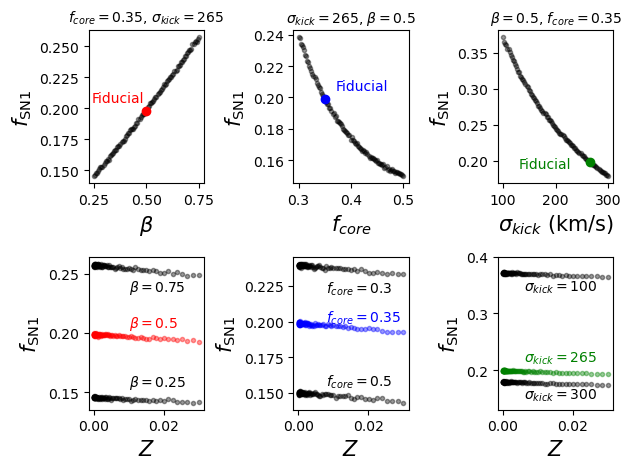

In [19]:
# Create a figure
fig = plt.figure()

# Create a grid of subplots (2 rows, 3 columns in this case)
ax1 = fig.add_subplot(2, 3, 1)  # 1st subfigure
ax2 = fig.add_subplot(2, 3, 2)  # 2nd subfigure
ax3 = fig.add_subplot(2, 3, 3)  # 3rd subfigure
ax4 = fig.add_subplot(2, 3, 4)  # 4th subfigure
ax5 = fig.add_subplot(2, 3, 5)  # 5th subfigure
ax6 = fig.add_subplot(2, 3, 6)  # 6th subfigure

# Plot something in each subfigure
ax1.scatter(betaarray, fSN1array_varbeta, color='k', marker='.', alpha=0.4)
ax1.scatter(0.5, fSN1array_varbeta[np.argmin(np.abs(betaarray-0.5))], color='r')
ax1.text(x=0.24, y=0.205, s='Fiducial', color='r', fontsize=10)

ax2.scatter(fcorearray, fSN1array_varfcore, color='k', marker='.', alpha=0.4)
ax2.scatter(0.35, fSN1array_varfcore[np.argmin(np.abs(fcorearray-0.35))], color='b')
ax2.text(x=0.37, y=0.205, s='Fiducial', color='b', fontsize=10)

ax3.scatter(sigmakickarray, fSN1array_varsigmakick, color='k', marker='.', alpha=0.4)
ax3.scatter(265.0, fSN1array_varsigmakick[np.argmin(np.abs(sigmakickarray-265.0))], color='g')
ax3.text(x=130, y=0.19, s='Fiducial', color='g', fontsize=10)

color = ['k', 'r', 'k']
for i in range(3):
    if i ==1:
        ax4.scatter(array_Z, fSN1_Z_varbeta[i], color=color[i], marker='.', alpha=0.4)
    else:
        ax4.scatter(array_Z, fSN1_Z_varbeta[i], color=color[i], marker='.', alpha=0.4)
ax4.text(x=0.01, y=0.235, s=r'$\beta=0.75$', color='k', fontsize=10)
ax4.text(x=0.01, y=0.205, s=r'$\beta=0.5$', color='r', fontsize=10)
ax4.text(x=0.01, y=0.155, s=r'$\beta=0.25$', color='k', fontsize=10)

color = ['k', 'b', 'k']
for i in range(3):
    if i ==1:
        ax5.scatter(array_Z, fSN1_Z_varfcore[i], color=color[i], marker='.', alpha=0.4)
    else:
        ax5.scatter(array_Z, fSN1_Z_varfcore[i], color=color[i], marker='.', alpha=0.4)
ax5.text(x=0.008, y=0.22, s=r'$f_{core}=0.3$', color='k', fontsize=10)
ax5.text(x=0.008, y=0.20, s=r'$f_{core}=0.35$', color='b', fontsize=10)
ax5.text(x=0.008, y=0.155, s=r'$f_{core}=0.5$', color='k', fontsize=10)

color = ['k', 'g', 'k']
for i in range(3):
    if i ==1:
        ax6.scatter(array_Z, fSN1_Z_varsigmakick[i], color=color[i], marker='.', alpha=0.4)
    else:
        ax6.scatter(array_Z, fSN1_Z_varsigmakick[i], color=color[i], marker='.', alpha=0.4)
ax6.text(x=0.006, y=0.34, s=r'$\sigma_{kick}=100$', color='k', fontsize=10)
ax6.text(x=0.006, y=0.215, s=r'$\sigma_{kick}=265$', color='g', fontsize=10)
ax6.text(x=0.006, y=0.15, s=r'$\sigma_{kick}=300$', color='k', fontsize=10)
ax6.set_ylim(0.13, 0.40)

# Add label and titles to each subfigure

ax1.set_xlabel(r'$\beta$', fontsize=15)
ax1.set_ylabel(r'$f_{\text{SN1}}$' , fontsize=15)
ax1.set_title(r'$f_{core}=0.35$, $\sigma_{kick}=265$', fontsize=10)

ax2.set_xlabel(r'$f_{core}$', fontsize=15)
ax2.set_ylabel(r'$f_{\text{SN1}}$' , fontsize=15)
ax2.set_title(r'$\sigma_{kick}=265$, $\beta=0.5$', fontsize=10)

ax3.set_xlabel(r'$\sigma_{kick}$ (km/s)', fontsize=15)
ax3.set_ylabel(r'$f_{\text{SN1}}$' , fontsize=15)
ax3.set_title(r'$\beta=0.5$, $f_{core}=0.35$', fontsize=10)

ax4.set_xlabel(r'$Z$', fontsize=15)
ax4.set_ylabel(r'$f_{\text{SN1}}$' , fontsize=15)

ax5.set_xlabel(r'$Z$', fontsize=15)
ax5.set_ylabel(r'$f_{\text{SN1}}$' , fontsize=15)

ax6.set_xlabel(r'$Z$', fontsize=15)
ax6.set_ylabel(r'$f_{\text{SN1}}$' , fontsize=15)

# Adjust layout so that subfigures don't overlap
plt.tight_layout()

plt.savefig('../plots/main.pdf')